In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load your time series dataset
data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

# Columns to convert to numeric
numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                   "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

# Use "." as decimal separator instead of ","
for col in numeric_columns:
    data[col] = data[col].str.replace(',', '.')

# Convert selected columns to numeric
# Parameter errors="coerce" converts problematic values into NaN
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

# FEATURE ENGINEERING
data['Timestamp'] = pd.to_datetime(data['ReadableDate'], errors="raise")
data['Date'] = data['Timestamp'].dt.date
data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL', 'Skewness.mean'], axis=1)

# Aggregate features within each window
agg_data = data.groupby('Date').agg(['median', 'std'])
# Flatten the MultiIndex columns (without this, columns are grouped)
agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
# Drop "FloatRUL_std", created when aggregating but not useful in the analysis: target = "FloatRUL_median"
agg_data = agg_data.drop("FloatRUL_std", axis=1)

floatRUL = agg_data["FloatRUL_median"]
agg_data = agg_data.drop("FloatRUL_median", axis=1)

# Define window size
window_size = 54  # Adjust window size as needed

# Create sliding windows
windows = []
labels = []
for i in range(len(agg_data) - window_size + 1):
    windows.append(agg_data.iloc[i : i + window_size])
    labels.append(floatRUL[i + window_size - 1])

final_cols = []
for col in windows[0].columns:
    final_cols.append(f'{col}_mean')
    final_cols.append(f'{col}_std')
    final_cols.append(f'{col}_min')
    final_cols.append(f'{col}_max')
    
final_agg = pd.DataFrame(columns=final_cols)
for i, window in enumerate(windows):
    row_values = []
    for col in window.columns:
        row_values.extend([window[col].mean(), window[col].std(), window[col].min(), window[col].max()])
    final_agg.loc[i] = row_values

# Split data into train, validation, and test sets: 70-15-15
train_size = int(0.70 * len(final_agg))
val_size = int(0.15 * len(final_agg))
X_train, X_val, X_test = final_agg[:train_size], final_agg[train_size:train_size+val_size], final_agg[train_size+val_size:]
y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]

In [2]:
# Build the RF model
model = RandomForestRegressor(n_estimators=270, n_jobs=-1, max_features="sqrt", min_samples_split=6, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate on the validation set
val_predictions = model.predict(X_val)
val_rmse = sqrt(mean_squared_error(y_val, val_predictions))
print(f'Validation RMSE: {val_rmse}')

# Evaluate on the test set
test_predictions = model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, test_predictions))
print(f'Test RMSE: {test_rmse}')

Validation RMSE: 14.784849406344174
Test RMSE: 17.079595055797903


In [3]:

for i in range(len(val_predictions)):
    print(val_predictions[i], y_val[i])

13.302539379997052 8.243865740740741
13.604814940439006 7.246412037037038
13.781913956825184 6.256712962962962
13.931547950385184 5.253067129629629
13.929963201102057 4.246180555555556
13.674284965656271 3.2484953703703705
14.52327483953042 2.2431712962962957
15.723233561129685 1.2452546296296296
15.833261253799881 0.4583912037037037
15.949172699681387 0.3459490740740741
15.852191842563395 13.85824074074074
16.15680211323776 12.868715277777778
17.234669930750712 11.918078703703706
17.865607835012874 10.8628125
17.776314899348666 9.869930555555557
17.732302700812127 8.862638888888887
17.901328570670813 7.838101851851851
18.32607010842619 6.882835648148147
18.865527778087422 5.92363425925926
18.939663126779365 4.866111111111112
18.947908547501385 3.8640277777777787
18.951868580883165 2.8633333333333333
19.066427837921395 1.8645486111111111
19.021051098706963 0.8632175925925926
18.980572290285455 6.49212962962963
19.037696062964105 5.89837962962963
19.35542097568225 4.898263888888889
19.5

In [3]:
from sklearn.model_selection import ParameterGrid

estimators = []
for i in range(50, 410, 10):
    estimators.append(i)

samplessplit = []
for i in range(2, 13):
    samplessplit.append(i)

param_grid = {"n_estimators": estimators,
              "max_features": ["sqrt", "log2"],
              "min_samples_split": samplessplit,
              "n_jobs": [-1],
              "random_state": [42]}


param_grid = ParameterGrid(param_grid)
best_score = float('-inf')
best_params = None
rf = RandomForestRegressor()
for i, params in enumerate(param_grid, start=1):
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    score = rf.score(X_val, y_val)
    print(f'Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}')
    if score > best_score:
        best_score = score
        best_params = params
best_rf_model = RandomForestRegressor()
best_rf_model.set_params(**best_params)
best_rf_model.fit(X_train, y_train)

Iteration 1/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}, Score: -16.28845275835578
Iteration 2/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 60, 'n_jobs': -1, 'random_state': 42}, Score: -15.07790110344002
Iteration 3/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 70, 'n_jobs': -1, 'random_state': 42}, Score: -15.592875850156542
Iteration 4/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 80, 'n_jobs': -1, 'random_state': 42}, Score: -14.694171226541243
Iteration 5/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 90, 'n_jobs': -1, 'random_state': 42}, Score: -14.969833546946534
Iteration 6/792 - Parameters: {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}, Score: -14.500175032940932
Iteration 7/792 - Parameters: {'max

RandomForestRegressor(max_features='log2', min_samples_split=3, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [4]:
print("R2 train set:", model.score(X_train, y_train))
print("R2 validation set:", model.score(X_val, y_val))
print("R2 test set:", model.score(X_test, y_test))

print("\nBest model according to CV Grid Search:")
print("R2 train set:", best_rf_model.score(X_train, y_train))
print("R2 validation set:", best_rf_model.score(X_val, y_val))
print("R2 test set:", best_rf_model.score(X_test, y_test))

R2 train set: 0.9753192203112386
R2 validation set: -17.104367854420694
R2 test set: -10.631903793206577

Best model according to CV Grid Search:
R2 train set: 0.9724271274645455
R2 validation set: -9.07593720107549
R2 test set: -7.0173834886210855


In [5]:
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')
print(best_score)
print(best_params)

Validation RMSE: 11.02980790151873
-9.075937201075487
{'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}


In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def test(window_size):
    # Load your time series dataset
    data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

    # Columns to convert to numeric
    numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                       "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

    # Use "." as decimal separator instead of ","
    for col in numeric_columns:
        data[col] = data[col].str.replace(',', '.')

    # Convert selected columns to numeric
    # Parameter errors="coerce" converts problematic values into NaN
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

    # FEATURE ENGINEERING
    data['Timestamp'] = pd.to_datetime(data['ReadableDate'], errors="raise")
    data['Date'] = data['Timestamp'].dt.date
    data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL', 'Skewness.mean'], axis=1)

    # Aggregate features within each window
    agg_data = data.groupby('Date').agg(['median', 'std'])
    # Flatten the MultiIndex columns (without this, columns are grouped)
    agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
    # Drop "FloatRUL_std", created when aggregating but not useful in the analysis: target = "FloatRUL_median"
    agg_data = agg_data.drop("FloatRUL_std", axis=1)

    floatRUL = agg_data["FloatRUL_median"]
    agg_data = agg_data.drop("FloatRUL_median", axis=1)
    
    # Create sliding windows
    windows = []
    labels = []
    for i in range(len(agg_data) - window_size + 1):
        windows.append(agg_data.iloc[i : i + window_size])
        labels.append(floatRUL[i + window_size - 1])

    final_cols = []
    for col in windows[0].columns:
        final_cols.append(f'{col}_mean')
        final_cols.append(f'{col}_std')
        final_cols.append(f'{col}_min')
        final_cols.append(f'{col}_max')

    final_agg = pd.DataFrame(columns=final_cols)
    for i, window in enumerate(windows):
        row_values = []
        for col in window.columns:
            row_values.extend([window[col].mean(), window[col].std(), window[col].min(), window[col].max()])
        final_agg.loc[i] = row_values

    # Split data into train, validation, and test sets: 70-15-15
    train_size = int(0.70 * len(final_agg))
    val_size = int(0.15 * len(final_agg))
    X_train, X_val, X_test = final_agg[:train_size], final_agg[train_size:train_size+val_size], final_agg[train_size+val_size:]
    y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]

    best_rf_model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_predictions = best_rf_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = sqrt(val_mse)
    
    return val_rmse, best_rf_model.score(X_val, y_val)

In [7]:
bestrmse = 99
for i in range(2, 60):
    rmse, score = test(i)
    print(f'window size {i}: RMSE = {rmse}, R2 = {score}')
    if rmse < bestrmse:
        bestrmse = rmse
        bestscore = score
        bestwindow = i
print(f'Best results: window size {bestwindow}: RMSE = {bestrmse}, R2 = {bestscore}')

window size 2: RMSE = 23.822436512729873, R2 = -14.63510791817285
window size 3: RMSE = 24.31849106373828, R2 = -15.293026903941485
window size 4: RMSE = 25.22107096907528, R2 = -16.524901076464932
window size 5: RMSE = 25.398476339972348, R2 = -18.455586572622956
window size 6: RMSE = 21.489663079533294, R2 = -12.927982556041204
window size 7: RMSE = 22.058210444706326, R2 = -13.674710846384434
window size 8: RMSE = 21.79353984777187, R2 = -13.324667658507416
window size 9: RMSE = 22.78798563774652, R2 = -16.314314212335226
window size 10: RMSE = 22.384593281520182, R2 = -15.706744703555355
window size 11: RMSE = 20.41970192205523, R2 = -12.902478009801044
window size 12: RMSE = 21.58123579282239, R2 = -15.872322353935143
window size 13: RMSE = 21.349735958636057, R2 = -15.512288244236391
window size 14: RMSE = 21.460087901603217, R2 = -15.683425935868321
window size 15: RMSE = 23.83234634952872, R2 = -22.253041925354697
window size 16: RMSE = 21.482843311036913, R2 = -17.469403255009

In [8]:
# Combine train and validation sets (resulting in a 85-15 split) in order to report final results
X_train_final, X_test_final = final_agg[:train_size+val_size], final_agg[train_size+val_size:]
y_train_final, y_test_final = labels[:train_size+val_size], labels[train_size+val_size:]

# Train the model
best_rf_model.fit(X_train_final, y_train_final)

# Evaluate on the test set
test_predictions = best_rf_model.predict(X_test_final)
test_rmse = sqrt(mean_squared_error(y_test_final, test_predictions))
print(f'Test RMSE: {test_rmse}')
print("R2 test set:", best_rf_model.score(X_test_final, y_test_final))

Test RMSE: 7.342906585359206
R2 test set: -1.1499663797136956


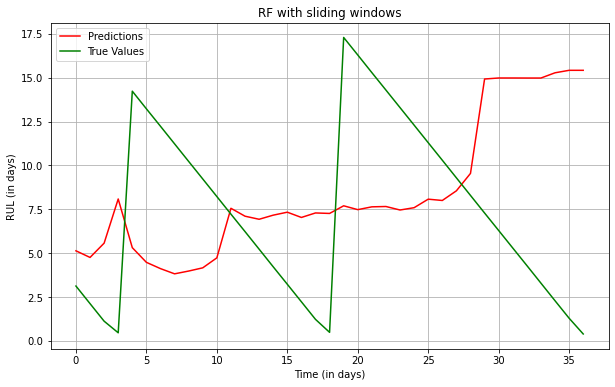

In [9]:
import matplotlib.pyplot as plt
import numpy as np

y_test_final_reset = y_test_final

# Convert the arrays to pandas Series
predictions_series = pd.Series(test_predictions, name="Predictions")
true_values_series = pd.Series(y_test_final_reset, name="True values")

# Concatenate the Series into a single DataFrame
df = pd.concat([predictions_series, true_values_series], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predictions', color='red')
plt.plot(y_test_final_reset, label='True Values', color='green')
plt.xlabel('Time (in days)')
plt.ylabel('RUL (in days)')
plt.title('RF with sliding windows')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig("Plot sliding window.pdf")

plt.show()